## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Initial EDA

In [2]:
df = pd.read_csv('ProjectDataset.csv')

In [3]:
df.head(3)

,state,playerid,wagerid,event_start,placed_date,settled_date,sportname,bet_type,result,net_stake,ggr,legresult,decimalodds
0,State1,3.065121e+07,1.693004e+06,2021-04-28 00:30:00+00,2021-04-27,2021-04-27,nhl,straight,won,6.64,-4.96,won,1.74627
1,State1,2.223717e+07,1.696371e+06,2021-04-28 01:45:00+00,2021-04-27,2021-04-27,nba,parlay,lost,5.00,5.00,won,1.78125
2,State1,2.223717e+07,1.696371e+06,2021-04-28 01:45:00+00,2021-04-27,2021-04-27,nba,parlay,lost,5.00,5.00,lost,1.86207


In [4]:
# check nulls

df.isna().sum()

state              0
playerid           0
wagerid            0
event_start        0
placed_date        0
settled_date       0
sportname          0
bet_type           0
result             0
net_stake          0
ggr                0
legresult          0
decimalodds     2472
dtype: int64

In [5]:
# dropping rows with null values because there are not many and are concentrated in one column 

df = df.dropna()

In [6]:
# column data types

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4172028 entries, 0 to 4174499
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   state         object 
 1   playerid      float64
 2   wagerid       float64
 3   event_start   object 
 4   placed_date   object 
 5   settled_date  object 
 6   sportname     object 
 7   bet_type      object 
 8   result        object 
 9   net_stake     float64
 10  ggr           float64
 11  legresult     object 
 12  decimalodds   float64
dtypes: float64(5), object(8)
memory usage: 445.6+ MB


In [7]:
# converting placed_date and settled_date to datetime objects for convenience later

df['placed_date'] = pd.to_datetime(df['placed_date'])
df['settled_date'] = pd.to_datetime(df['settled_date'])

In [8]:
# converting playerid and wagerid to string objects to avoid confusion later

df['playerid'] = df['playerid'].astype(str)
df['wagerid'] = df['wagerid'].astype(str)

In [9]:
df.head()

,state,playerid,wagerid,event_start,placed_date,settled_date,sportname,bet_type,result,net_stake,ggr,legresult,decimalodds
0,State1,30651211.8,1693004.1579375,2021-04-28 00:30:00+00,2021-04-27,2021-04-27,nhl,straight,won,6.64,-4.96,won,1.74627
1,State1,22237170.912,1696370.6029375,2021-04-28 01:45:00+00,2021-04-27,2021-04-27,nba,parlay,lost,5.00,5.00,won,1.78125
2,State1,22237170.912,1696370.6029375,2021-04-28 01:45:00+00,2021-04-27,2021-04-27,nba,parlay,lost,5.00,5.00,lost,1.86207
3,State1,22237170.912,1696370.6029375,2021-04-28 01:45:00+00,2021-04-27,2021-04-27,nba,parlay,lost,5.00,5.00,lost,1.74627
4,State1,22237170.912,1696370.6029375,2021-04-28 01:45:00+00,2021-04-27,2021-04-27,nba,parlay,lost,5.00,5.00,lost,1.78125


In [10]:
# unique value count of every column

df.nunique()

state                 3
playerid          36387
wagerid         2401372
event_start       11991
placed_date         366
settled_date        367
sportname             7
bet_type              2
result                2
net_stake         31695
ggr               96958
legresult             5
decimalodds       18694
dtype: int64

## Adjusting Dataframe + more EDA

Changing the dataframe so it does not list each leg of a parlay bet as an individual bets.

In [11]:
# columns
agg = {x:'min' for x in df.columns if x not in ['wagerid', 'net_stake', 'ggr','decimalodds']}
agg.update({'state':'min', 'net_stake':'sum','ggr':'sum','decimalodds':np.prod})

# new dataframe grouping by wagerid value
grouped = df.groupby(['wagerid']).agg(agg)

# resetting index so wagerid is a column
grouped = grouped.reset_index()

# drop legresult column because it is not needed here
grouped.drop(columns=['legresult'], inplace=True)

# round monetary values to 2 decimal places
grouped[['net_stake', 'ggr']] = grouped[['net_stake', 'ggr']].round(2)

In [12]:
# testing to confirm grouping worked as intended
grouped[grouped['wagerid'] == '1696370.6029375']

,wagerid,state,playerid,event_start,placed_date,settled_date,sportname,bet_type,result,net_stake,ggr,decimalodds
357760,1696370.6029375,State1,22237170.912,2021-04-28 01:45:00+00,2021-04-27,2021-04-27,nba,parlay,lost,20.0,20.0,10.317088


In [13]:
grouped.describe()

,net_stake,ggr,decimalodds
count,2.401372e+06,2.401372e+06,2.401372e+06
mean,4.103786e+01,4.257739e+00,1.846897e+01
std,1.117049e+02,1.403621e+02,2.751939e+03
min,4.010000e+00,-2.100000e+04,1.001000e+00
25%,1.000000e+01,-9.010000e+00,1.909090e+00
50%,2.000000e+01,1.000000e+01,2.400000e+00
75%,4.000000e+01,2.500000e+01,6.900000e+00
max,1.967200e+04,1.967200e+04,4.169540e+06


In [14]:
grouped['sportname'].value_counts(normalize=True)

nfl                   0.314255
nba                   0.301449
college basketball    0.141945
mlb                   0.122300
college football      0.072277
nhl                   0.042657
champions league      0.005117
Name: sportname, dtype: float64

<AxesSubplot:>

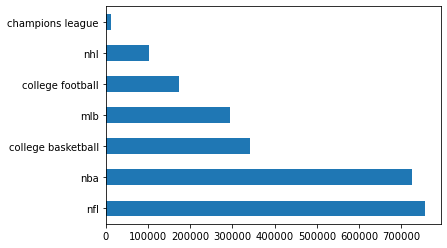

In [15]:
grouped['sportname'].value_counts().plot(kind='barh')

In [16]:
grouped.corr().style.background_gradient(cmap='coolwarm')

,net_stake,ggr,decimalodds
net_stake,1.000000,0.055301,0.000866
ggr,0.055301,1.000000,0.001375
decimalodds,0.000866,0.001375,1.000000


## GGR-related analysis

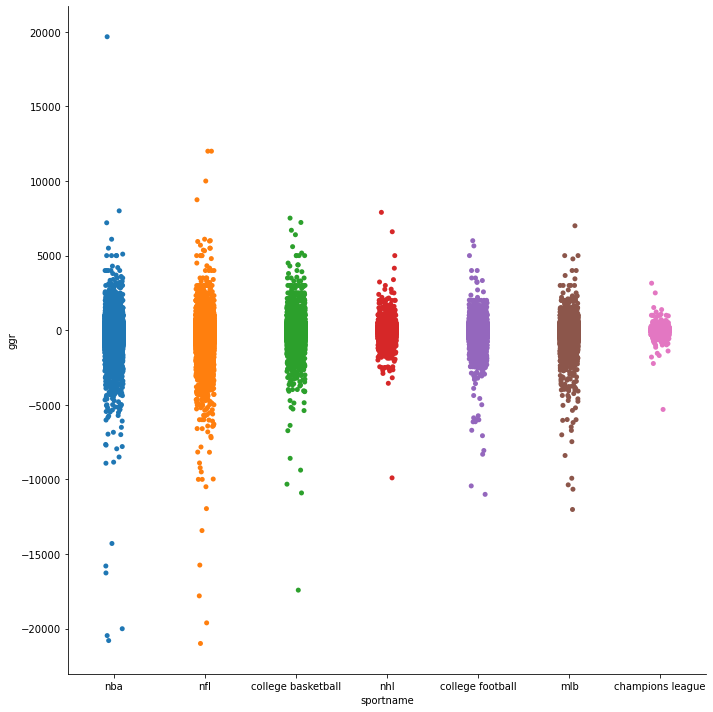

In [17]:
sns.catplot(data=grouped, x="sportname", y="ggr", height=10)

In [18]:
grouped.groupby(['sportname'])['net_stake', 'ggr'].describe()

net_stake                                                  \
                       count       mean         std   min   25%   50%    75%   
sportname                                                                      
champions league     12289.0  36.149076   93.815174  4.06  10.0  20.0  37.31   
college basketball  340862.0  42.986723  123.462828  4.01  10.0  20.0  44.00   
college football    173565.0  47.276433  109.050512  4.01  10.0  23.0  50.00   
mlb                 293687.0  40.811768  105.735724  4.01  10.0  20.0  43.00   
nba                 723890.0  39.546927  103.590461  4.01  10.0  20.0  40.00   
nfl                 754643.0  41.180802  117.923971  4.01  10.0  20.0  40.00   
nhl                 102436.0  34.700058  100.599760  4.01  10.0  15.0  26.00   

                                  ggr                                          \
                        max     count      mean         std       min     25%   
sportname                                                                       
champions league     4850.0   12289.0  6.505275  108.118876  -5312.42  -3.820   
college basketball  12000.0  340862.0  2.951636  134.307160 -17424.72 -12.410   
college football    10000.0  173565.0  3.893866  138.167493 -11004.09 -14.340   
mlb                 12400.0  293687.0  4.462842  131.985883 -12018.13  -9.095   
nba                 19672.0  723890.0  4.479795  142.979736 -20805.63  -8.200   
nfl                 15000.0  754643.0  4.765587  148.126584 -21000.00  -5.150   
nhl                  7900.0  102436.0  3.052232  109.636645  -9899.44 -10.000   

                                          
                     50%   75%       max  
sportname                                 
champions league    10.0  25.0   3150.00  
college basketball   7.5  25.0   7513.93  
college football    10.0  25.0   6000.00  
mlb                 10.0  25.0   7000.00  
nba                 10.0  25.0  19672.00  
nfl                 10.0  25.0  12000.00  
nhl                  5.0  20.0   7900.00

In [19]:
grouped.groupby(['sportname'])['ggr'].sum()

sportname
champions league        79943.33
college basketball    1006100.38
college football       675838.84
mlb                   1310678.56
nba                   3242879.02
nfl                   3596316.60
nhl                    312658.48
Name: ggr, dtype: float64

In [20]:
grouped['ggr'].sum().round(2)

10224415.21

In [21]:
# nfl                   0.314255
# nba                   0.301449
# college basketball    0.141945
# mlb                   0.122300
# college football      0.072277
# nhl                   0.042657
# champions league      0.005117

print("NFL percentage of total GGR:", 3596316.60/10224415.21)
print("NBA percentage of total GGR:", 3242879.02/10224415.21)
print("CBB percentage of total GGR:", 1006100.38/10224415.21)
print("MLB percentage of total GGR:", 1310678.56/10224415.21)
print("CFB percentage of total GGR:", 675838.84/10224415.21)
print("NHL percentage of total GGR:", 312658.48/10224415.21)
print("CL percentage of total GGR:", 79943.33/10224415.21)

NFL percentage of total GGR: 0.3517381215585434
NBA percentage of total GGR: 0.31717012204554235
CBB percentage of total GGR: 0.09840175299375385
MLB percentage of total GGR: 0.12819105377470286
CFB percentage of total GGR: 0.06610048849923417
NHL percentage of total GGR: 0.030579595368369236
CL percentage of total GGR: 0.007818865759854054


## Bet Type-related analysis

In [22]:
grouped['bet_type'].value_counts(normalize=True)

straight    0.714134
parlay      0.285866
Name: bet_type, dtype: float64

In [23]:
# mean, std, min, max of net_stake and ggr grouped by the type of bet

grouped.groupby(['bet_type'])['net_stake', 'ggr'].describe()

net_stake                                                           \
              count       mean         std   min    25%   50%   75%      max   
bet_type                                                                       
parlay     686470.0  45.258926   78.105906  4.01  20.00  25.0  50.0   8000.0   
straight  1714902.0  39.348176  122.559705  4.01   8.02  15.0  30.0  19672.0   

                ggr                                                     \
              count      mean         std       min   25%   50%    75%   
bet_type                                                                 
parlay     686470.0  9.263691  182.876639 -20805.63  10.0  25.0  47.42   
straight  1714902.0  2.253872  119.106903 -21000.00 -10.8   5.0  20.00   

                    
               max  
bet_type            
parlay     7222.22  
straight  19672.00

In [24]:
# which type of bet is more common in each sport

grouped['bet_type'].groupby(grouped['sportname']).value_counts(normalize=True)

sportname           bet_type
champions league    straight    0.610221
                    parlay      0.389779
college basketball  straight    0.736354
                    parlay      0.263646
college football    straight    0.750624
                    parlay      0.249376
mlb                 straight    0.681069
                    parlay      0.318931
nba                 straight    0.699159
                    parlay      0.300841
nfl                 straight    0.712126
                    parlay      0.287874
nhl                 straight    0.806260
                    parlay      0.193740
Name: bet_type, dtype: float64

In [25]:
# which sport are players placing which bets on

grouped['sportname'].groupby(grouped['bet_type']).value_counts(normalize=True)

bet_type  sportname         
parlay    nba                   0.317240
          nfl                   0.316462
          mlb                   0.136446
          college basketball    0.130912
          college football      0.063052
          nhl                   0.028910
          champions league      0.006978
straight  nfl                   0.313371
          nba                   0.295127
          college basketball    0.146361
          mlb                   0.116637
          college football      0.075971
          nhl                   0.048160
          champions league      0.004373
Name: sportname, dtype: float64

## Location-related analysis

In [26]:
# which state contributed to how much of the total bets

grouped['state'].value_counts(normalize=True)

State2    0.356947
State3    0.347574
State1    0.295479
Name: state, dtype: float64

In [27]:
# amount of bets from each state that are placed toward each sport

grouped['sportname'].groupby(grouped['state']).value_counts(normalize=True)

state   sportname         
State1  nba                   0.305781
        nfl                   0.245122
        college basketball    0.183922
        mlb                   0.151403
        college football      0.070347
        nhl                   0.039528
        champions league      0.003897
State2  nfl                   0.342554
        nba                   0.293526
        mlb                   0.138417
        college basketball    0.108416
        college football      0.068222
        nhl                   0.042822
        champions league      0.006044
State3  nfl                   0.343964
        nba                   0.305902
        college basketball    0.140692
        mlb                   0.081006
        college football      0.078084
        nhl                   0.045149
        champions league      0.005203
Name: sportname, dtype: float64

In [28]:
# another way to look at above data, part of all bets toward a sport that were placed by each state

grouped['state'].groupby(grouped['sportname']).value_counts(normalize=True)

sportname           state 
champions league    State2    0.421597
                    State3    0.353405
                    State1    0.224998
college basketball  State1    0.382862
                    State3    0.344506
                    State2    0.272632
college football    State3    0.375496
                    State2    0.336917
                    State1    0.287587
mlb                 State2    0.403988
                    State1    0.365794
                    State3    0.230218
nba                 State3    0.352708
                    State2    0.347565
                    State1    0.299726
nfl                 State2    0.389090
                    State3    0.380433
                    State1    0.230477
nhl                 State3    0.367878
                    State2    0.358321
                    State1    0.273800
Name: state, dtype: float64

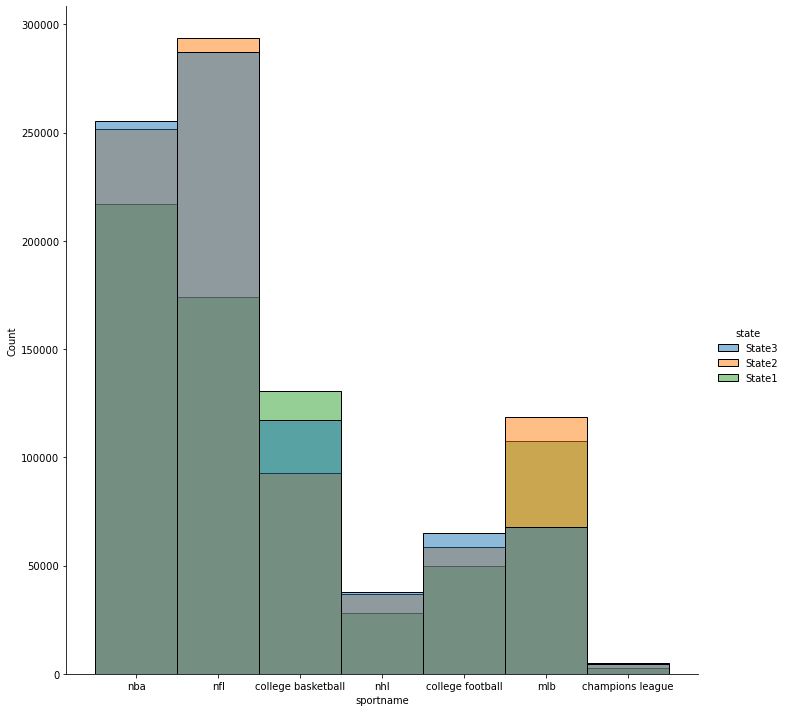

In [29]:
# visualization of wager distribution across the sports by state

sns.displot(grouped, x="sportname", hue="state", height=10)

In [30]:
# user count by state

grouped['playerid'].groupby(grouped['state']).nunique()

state
State1    10543
State2    16072
State3    14240
Name: playerid, dtype: int64

In [31]:
# average ggr by state

grouped['ggr'].groupby(grouped['state']).mean()

state
State1    3.275773
State2    5.756162
State3    3.553697
Name: ggr, dtype: float64

## Date-related analysis

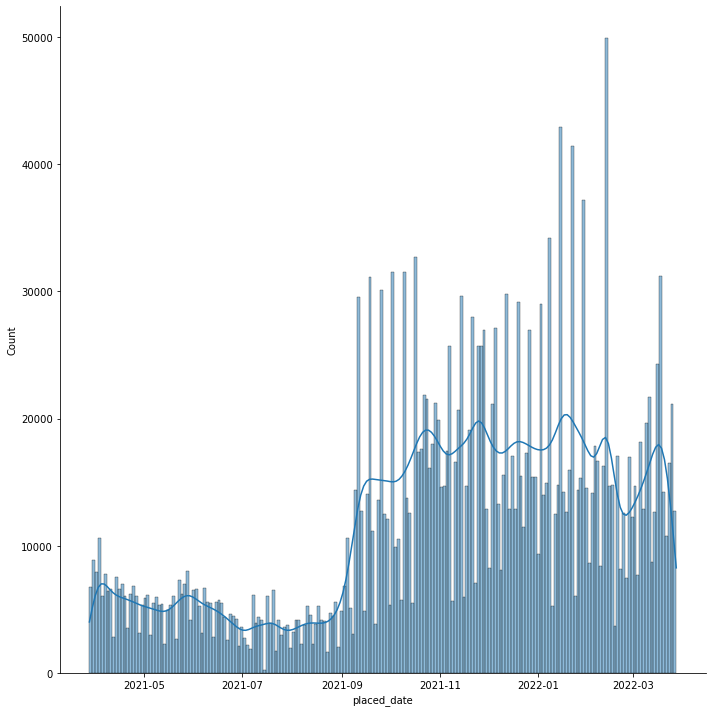

In [32]:
sns.displot(grouped, x="placed_date", kde=True, height=10)

## ?

In [33]:
grouped['playerid'].groupby(grouped['sportname']).nunique()

sportname
champions league       3099
college basketball    15608
college football      13195
mlb                   13788
nba                   23080
nfl                   28367
nhl                    8274
Name: playerid, dtype: int64

In [34]:
grouped['wagerid'].groupby(grouped['sportname']).nunique()

sportname
champions league       12289
college basketball    340862
college football      173565
mlb                   293687
nba                   723890
nfl                   754643
nhl                   102436
Name: wagerid, dtype: int64